In [11]:
# Enable interactive plot
%matplotlib inline


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import datasets, linear_model
import matplotlib as mpl
from scipy.stats import linregress
from svgpathtools import svg2paths
from svgpath2mpl import parse_path

import warnings

# Warnungen vom Typ DeprecationWarning ignorieren
warnings.filterwarnings("ignore")


In [12]:
# set figures size
mpl.rcParams["figure.figsize"] = (12, 10)

# set font family to Arial
mpl.rcParams["font.family"] = "Arial"

# Ändern der Standard-Schriftgröße für Titel
mpl.rcParams["axes.titlesize"] = 16

# Ändern des Standard-Abstands für den Titel global
mpl.rcParams["axes.titlepad"] = 20

mpl.rcParams["axes.titlelocation"] = "left"

mpl.rcParams["axes.titleweight"] = "bold"

mpl.rcParams["figure.titlesize"] = 20

mpl.rcParams["figure.titleweight"] = "bold"

# Modify the default background color
plt.rcParams["figure.facecolor"] = "#e6e6e6"

plt.rcParams["axes.facecolor"] = "#e6e6e6"

# Setze die Achsenfarben in den rcParams
plt.rcParams["axes.edgecolor"] = "white"

plt.rcParams["axes.labelcolor"] = "black"

x_tick_steps = 5

# Subttitel options
subtitle_size = 12
subtitle_x_pos = 0
subtitle_y_pos = 1.01
subtitle_pos = [subtitle_x_pos, subtitle_y_pos]

In [13]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score, mean_absolute_percentage_error


class ARIMATimeSeriesForecast:
    """
    A class for time series forecasting using the ARIMA model.

    Parameters:
    - data (pd.DataFrame): The time series data.
    - target_column (str): The name of the target column to be forecasted.
    """

    def __init__(self, data, target_column):
        """
        Initializes the ARIMATimeSeriesForecast object.

        Parameters:
        - data (pd.DataFrame): The time series data.
        - target_column (str): The name of the target column to be forecasted.
        """
        self.data = data
        self.target_column = target_column

    def fit(self, order=(3, 1, 2), test_size=0.3, forecast_steps=30):
        """
        Fits the ARIMA model to the training data.

        Parameters:
        - order (tuple): The order of the ARIMA model (p, d, q).
        - test_size (float): The proportion of data to be used for testing.
        - forecast_steps (int): The number of steps to forecast into the future.
        """
        self.train, self.test = self.train_test_split(test_size)
        self.model = ARIMA(self.train[self.target_column], order=order)
        self.model = self.model.fit()

        self.prediction_start = len(self.train)
        self.prediction_end = len(self.train) + len(self.test) - 1 + forecast_steps

    def train_test_split(self, test_size):
        """
        Splits the data into training and testing sets.

        Parameters:
        - test_size (float): The proportion of data to be used for testing.

        Returns:
        - train (pd.DataFrame): The training data.
        - test (pd.DataFrame): The testing data.
        """
        train_size = int(len(self.data) * (1 - test_size))
        train, test = self.data[:train_size], self.data[train_size:]
        return train, test

    def set_index(self):
        """Sets the index for the predicted data based on the test data."""
        new_index = []
        for index_value in range(
            self.test.index[0], self.test.index[0] + len(self.pred)
        ):
            new_index.append(index_value)
        self.pred.index = new_index

    def predict(self):
        """
        Makes predictions using the fitted ARIMA model.

        Returns:
        - pred (pd.Series): The predicted values.
        """
        self.pred = self.model.predict(
            start=self.prediction_start, end=self.prediction_end, typ="levels"
        )
        self.set_index()
        return self.pred

    def evaluate(self):
        """
        Evaluates the model performance using R-squared and MAPE.

        Returns:
        - r2 (float): R-squared score.
        - mape (float): Mean Absolute Percentage Error.
        """
        r2 = r2_score(self.test[self.target_column], self.pred[: len(self.test)])
        mape = mean_absolute_percentage_error(
            self.test[self.target_column], self.pred[: len(self.test)]
        )
        return r2, mape

    def plot_results(self, title, x_label="Date", y_label=""):
        """
        Plots the results, including the predicted, test, and train data, along with confidence intervals.

        Parameters:
        - title (str): The title of the plot.
        - x_label (str): The label for the x-axis.
        - y_label (str): The label for the y-axis.

        Returns:
        - fig (matplotlib.figure.Figure): The matplotlib figure.
        - ax (matplotlib.axes._subplots.AxesSubplot): The matplotlib axes.
        """
        forecast = self.model.get_forecast(
            steps=self.prediction_end - self.prediction_start + 1
        )
        lower_bound = forecast.conf_int()["lower " + self.target_column].values
        upper_bound = forecast.conf_int()["upper " + self.target_column].values

        r2, mape = self.evaluate()

        fig, ax = plt.subplots()
        ax.plot(self.pred.index, self.pred.values, color="red", label="Predicted Data")
        ax.plot(
            self.test.index,
            self.test[self.target_column],
            color="green",
            label="Test Data",
            lw=3,
        )
        ax.plot(
            self.train.index,
            self.train[self.target_column],
            color="black",
            label="Train Data",
        )
        ax.fill_between(self.pred.index, lower_bound, upper_bound, color="k", alpha=0.1)

        ax.set_title(
            f"{title} ({self.train.index[0]} - {self.test.index[-1]})", x=-0.06, y=1.01
        )
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.legend()
        ax.text(
            0.85,
            0.3,
            f"$R^2$= {r2:.3f} \nMAPE= {mape:.3f}",
            transform=ax.transAxes,
            va="bottom",
        )
        return fig, ax

In [14]:
def nice_axes(ax, axis="x"):
    # Configure grid and axis visibility

    ax.grid(True, axis=axis, color="white")

    ax.set_axisbelow(True)
    # Hide the spines

    [spine.set_visible(False) for spine in ax.spines.values()]


def get_distance_to_next_text(fig, fig_tex, spacing=0.009):
    # get text bounding box in figure coordinates

    renderer = fig.canvas.get_renderer()

    bbox_text = fig_tex.get_window_extent(renderer=renderer)

    # Get x0 and x1 values from the bounding box

    x0, _ = bbox_text.get_points()[0]

    x1, _ = bbox_text.get_points()[1]

    # Get the DPI (dots per inch) of the figure

    dpi = fig.get_dpi()

    # Calculate the distance to the next text based on x1, DPI, and figure width

    distance_to_next_text = (x1 / dpi) / fig.get_figwidth() + spacing

    return distance_to_next_text


def calculate_trend_decision(data):
    # Calculate the trend line with linear regression

    x = np.arange(len(data))

    slope, _, _, _, _ = linregress(x, data)

    # print(slope)

    # Make the decision based on the trend

    if slope > 0.02:
        return "Positive"

    elif slope < -0.02:
        return "Negative"

    else:
        return "None"  # Commented out the print statement


def intercept_slope_reg(x_reg, y_reg):
    """
    Calculate the slope and intercept of a linear regression model.

    Args:
    - x_reg: Input data (independent variable) reshaped as a column vector.
    - y_reg: Output data (dependent variable).

    Returns:
    - Tuple containing the slope and intercept of the linear regression model.
    """
    # Reshape input data

    x_reg = x_reg.reshape(-1, 1)
    # Create a linear regression model

    regr = linear_model.LinearRegression()
    # Fit the model to the data

    regr = regr.fit(x_reg, y_reg)
    # Get the slope and intercept

    slope = regr.coef_

    intercept = regr.intercept_
    return (slope, intercept)


def predict_over_time(time_seies, slope, intercept):
    """
    Predict values over time using a linear regression model.

    Args:
    - time_series: List or array of time points.
    - slope: Slope of the linear regression model.
    - intercept: Intercept of the linear regression model.

    Returns:
    - List of predicted values over time.
    """

    y_predicts = []

    for x in time_seies:
        # Predict the value at each time point using the linear regression equation

        y_predict = float(intercept) + float(slope) * x

        y_predicts.append(y_predict)

    return y_predicts


def prognose_reg(x, reg_x, reg_y):
    """
    Generate a prognosis using linear regression.

    Args:
    - x: List or array of input values for which to generate a prognosis.
    - reg_x: Input data (independent variable) used for linear regression.
    - reg_y: Output data (dependent variable) used for linear regression.

    Returns:
    - List of prognosticated values based on the linear regression model.
    """

    y_prognose = []
    # Obtain slope and intercept from linear regression

    slope, intercept = intercept_slope_reg(reg_x, reg_y)

    for i in x:
        # Generate a prognosis for each input value using the linear regression equation

        p = intercept + float(slope) * i

        y_prognose.append(round(p, 3))

    return y_prognose


def plot(ax, x, y):
    """
    Plot data on a given axis.

    Args:
    - ax: Matplotlib axis on which to plot the data.
    - x: List or array of x-axis values.
    - y: List of lists, where each inner list contains data and styling information for a plot.

    Each y entry should be in the format:
    [data, color, label, linestyle, linewidth]
    """

    for i in y:
        if len(i) != 5:
            raise ValueError(
                f"y sind nicht alle werte gegeben [[data], coler, label,ls , lw ]: {i}"
            )

        y_plot = i[0]

        coler = i[1]

        label = i[2]

        ls = i[3]

        lw = i[4]
        ax.plot(x, y_plot, color=coler, label=label, ls=ls, lw=lw)


def check_goals(
    ax,
    x,
    y,
    titel,
    xlabel,
    ylabel,
    gole,
    range_gole,
    ymin,
    ymax,
    subplots_adjust=0.2,
    ticks=2,
    ncol=2,
):
    """gole= ([[gole1,coler,label,ls,lw],[[golen,coler,label,ls,lw]])
    y = [[data],coler, label,ls,lw ]
    """

    s_gole, e_gole = range_gole

    x_gole = [x for x in range(s_gole, e_gole)]

    x = np.array(x)

    plot(ax, x, y)

    for g in gole:
        g[0] = np.ones(len(x_gole)) * g[0]

    plot(ax, x_gole, gole)

    reg_x = x.reshape((-1, 1))

    reg_y = y[0][0]

    y_prog = prognose_reg(x_gole, reg_x, reg_y)

    ax.plot(x_gole, y_prog, color="red", label="Regression rate", ls="-.")

    ax.set_title(titel, x=-0.06, y=1.01)

    ax.set_xlabel(xlabel)

    ax.set_ylabel(ylabel)

    ax.legend(
        loc="lower left",
        bbox_transform=fig.transFigure,
        fancybox=True,
        shadow=True,
        ncol=2,
    )

    plt.subplots_adjust(bottom=subplots_adjust)

    plt.xticks([x for x in range(s_gole, e_gole, x_tick_steps)])

    plt.ylim(top=ymax)

    plt.ylim(bottom=ymin)
    nice_axes(ax)
    return ax


def clean_and_convert_to_int(df, columns_to_clean):
    """
    Cleans data in specified columns of a DataFrame.
    Args:
    - df: The input DataFrame.
    - columns_to_clean: A list of column names to clean and convert to int64.
    Returns:
    - A DataFrame with cleaned and converted columns.
    """

    # Make a copy of the input DataFrame to avoid modifying the original

    cleaned_df = df.copy()

    for column in columns_to_clean:
        # Replace non-integer values with NaN

        cleaned_df[column] = pd.to_numeric(cleaned_df[column], errors="coerce")

        # Convert to int64, handling NaN values as needed (e.g., filling with 0)

        cleaned_df[column] = cleaned_df[column].fillna(0).astype("int64")

    return cleaned_df


def multiple_colors_subtitel(fig, subtitle, subtitle_pos):
    """
    Create subtitle with multiple colors

    Args:
    - subtitle: List of List [['Text 1', color Text 1, weight],['Text 2', coler Text 2, weight]] weight= bold, normal, small
    - subtitle_pos: A list of [x Postion, Y Postion]
    """
    for text_list in subtitle:
        fig_text = fig.text(
            subtitle_pos[0],
            subtitle_pos[1],
            text_list[0],
            color=text_list[1],
            fontproperties={
                "family": "Arial",
                "size": subtitle_size,
                "weight": text_list[2],
            },
            bbox={
                "alpha": 0.3,
                "facecolor": "#071126",
                "boxstyle": "square, pad=0.06",
                "edgecolor": "none",
            },
        )
        x = get_distance_to_next_text(fig, fig_text, 0.0018)
        subtitle_pos = [x, subtitle_pos[1]]


def svg_to_marker(path, rotate_deg=180):
    """
    Convert an SVG path to a marker for use in plotting.

    Args:
    - path: Path to an SVG file.

    Returns:
    - Marker object ready to be used in a Matplotlib plot.
    """
    # Parse the SVG file to get the path and attributes
    svg_path, attributes = svg2paths(path)
    # Extract the path from the attributes
    marker = parse_path(attributes[0]["d"])
    # Center the marker at the origin by subtracting the mean of its vertices
    marker.vertices -= marker.vertices.mean(axis=0)
    # Rotate the marker 180 degrees using an affine transformation
    marker = marker.transformed(mpl.transforms.Affine2D().rotate_deg(rotate_deg))
    # Scale the marker to reverse its direction along the x-axis
    marker = marker.transformed(mpl.transforms.Affine2D().scale(-1, 1))
    return marker

# Climate Change in Switzerland

This blog post explores the topic of climate change in Switzerland. Climate change is a global phenomenon involving alterations in climate patterns. The associated cooling or warming can occur over varying time frames. Currently, human activities, particularly the emission of greenhouse gases, contribute to global warming. Greenhouse gases such as water vapor, carbon dioxide, and methane induce a greenhouse effect in the Earth's atmosphere. The atmospheric greenhouse effect can be analogously visualized as the warming of a greenhouse. Sun rays can penetrate the system, heating matter inside. The generated heat is distributed within the system through infrared radiation and convection of heated air. In both systems, however, the rising warm air remains trapped inside. In the case of a greenhouse, the glass roof acts as a barrier against convection, while on Earth, the gravitational field maintains warm air in the atmosphere.

A specific form of climate change is abrupt climate variability. Throughout Earth's history, these variations have been triggered by supervolcano eruptions, extensive magma outflows, significantly increased greenhouse gas emissions, rapid changes in ocean currents, or short-term feedback processes in the climate system, often associated with biological crises or mass extinctions.

Source: [Wikipedia - Climate Change](https://en.wikipedia.org/wiki/Climate_change)

It is scientifically challenging to attribute individual weather events to current climate change. However, statistical evidence supports the idea that global warming increases the likelihood of extreme weather events.

**Possible direct consequences of human-induced climate change include:**

- Rising maximum temperatures
- Rising minimum temperatures
- Rising sea levels
- Higher sea temperatures
- Increasing heavy precipitation (torrential rain and hail)
- Increase in the intensity of tropical cyclones
- Growth of drought conditions
- Decline in Arctic sea ice and snow cover
- Glacier retreat and reduction

**Possible indirect consequences of climate change affecting humans and our environment include:**

- Increase in hunger and water crises, especially in developing countries
- Existential threat from floods and wildfires
- Health risks due to the frequency and intensity of heat extremes
- Economic consequences for mitigating climate-related damages
- Further spread of pests and pathogens
- Loss of biodiversity due to limited adaptability and speed of flora and fauna
- Necessity for adaptation in various sectors (e.g., agriculture, forestry, energy, infrastructure, tourism, etc.)

Source: [IPCC Report 2021](Quellen\IPCC_AR6_WGI_TS.pdf)


## Greenhouse Gases

Over the past 20 years, the resident population in Switzerland has grown by 1.5 million, representing an approximately 21% increase. On average, the resident population in Switzerland grows by 0.96%.

In contrast, greenhouse gas emissions per capita in Switzerland have decreased by 2.12 tons of CO2-equivalent over the last 20 years. This corresponds to an approximate reduction in greenhouse gas emissions per capita of 34.7%. CO2-equivalent represents the sum of all gases. Gases that are not CO2 emissions have been converted based on their Global Warming Potential (GWP) (IPCC, Fourth Assessment Report).


In [15]:
# Define the columns with their respective labels, colors, and line styles
colms_co2 = {
    "Total_co2a_1": ["Total 1.)", "#ffd700", "-"],
    "Energie_co2a": [
        "Energy (excluding transport, including waste incineration)",
        "#000000",
        "-",
    ],
    "Transport_co2a": [
        "Transport (excluding international air traffic)",
        "#a52a2a",
        "-",
    ],
    "Internationaler_Flug_co2a": [
        "International air and shipping traffic",
        "#ff1dce",
        "-",
    ],
    "Industrielle_co2a": ["Industrial processes and solvents", "#ffc40c", "-"],
    "Landnutzungsänderung_co2a": [
        "Land use change/forestry \nincluding wood products",
        "#ff00ff",
        "-",
    ],
    "Landwirtschaft_co2a": ["Agriculture", "#8db600", "-"],
    "Abfall_co2a": ["Waste (without waste incineration)", "#e30022", "-"],
}


colmos_goal = {
    "Ziel": ["#e03c31", "-", 3, "Netto-Null Ziel"],
    "progrnos_2018": ["#0000ff", "-.", 1, "Linear regression since 2018"],
    "progrnos_1990": ["#b5a642", "-.", 1, "Linear regression since 1990"],
    "Total_co2a_1": ["#000000", "-", 3, "Total CO2-eq 1)"],
}


# Create a new dictionary for transformation
colms_co2_transformed = {
    "column_header": list(colms_co2.keys()),
    "name": [value[0] for value in colms_co2.values()],
    "color": [value[1] for value in colms_co2.values()],
    "line_style": [value[2] for value in colms_co2.values()],
}

# Create a Pandas DataFrame
df_co2_columns = pd.DataFrame(colms_co2_transformed)

In [16]:
# Read data from Excel into a DataFrame and set the 'Jahr' column as the index
df_co2_con = pd.read_excel(
    "Daten/Treibhausgasemissionen_nach_verbrauchergruppen.xlsx", sheet_name="Tabelle1"
)
df_co2_con.set_index("Jahr", inplace=True)

df_b = pd.read_excel(
    "Daten/Bevölkerungswachstum.xlsx",
    sheet_name="Tabelle1",
)
df_b.set_index("Jahr", inplace=True)

df_enver = pd.read_excel(
    "Daten/Endenergieverbrauch_nach_Energieträger.xlsx",
    sheet_name="Tabelle1",
    usecols=[
        "Jahr",
        "Brennstoffe",
        "Treibstoffe",
        "Elektrizität",
        "Gas",
        "Kohle",
        "Holz und Holzkohle",
        "übrige Energieträger",
    ],
)
df_enver.set_index("Jahr", inplace=True)

df_EP2050_Electricity = pd.read_excel(
    "Daten/EP2050+Srtom.xlsx",
    sheet_name="Tabelle1",
    usecols=[
        "Jahr",
        "Landesverbrauch  ZERO Basis Pro Person",
        "Landesverbrauch WWB Pro Person",
    ],
)

df_el = pd.read_excel("Daten/Elektrizitätserzeugung_in_GWh.xlsx", sheet_name="Tabelle1")
df_el.set_index("Jahr", inplace=True)

df_Energieeinfuhr_und_ausfuhr = pd.read_excel(
    "Daten/Energieeinfuhr_und_ausfuhr.xlsx", sheet_name="Tabelle1"
)

df_Energieeinfuhr_und_ausfuhr = clean_and_convert_to_int(
    df_Energieeinfuhr_und_ausfuhr, df_Energieeinfuhr_und_ausfuhr.columns.to_list()
)
df_Energieeinfuhr_und_ausfuhr.set_index("Jahr", inplace=True)

In [17]:
# Filter columns based on the defined headers, rename them, and store in df_co2_con DataFrame
df_co2_con = df_co2_con[df_co2_columns.column_header].rename(
    columns=dict(zip(df_co2_columns.column_header.values, df_co2_columns.name.values))
)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

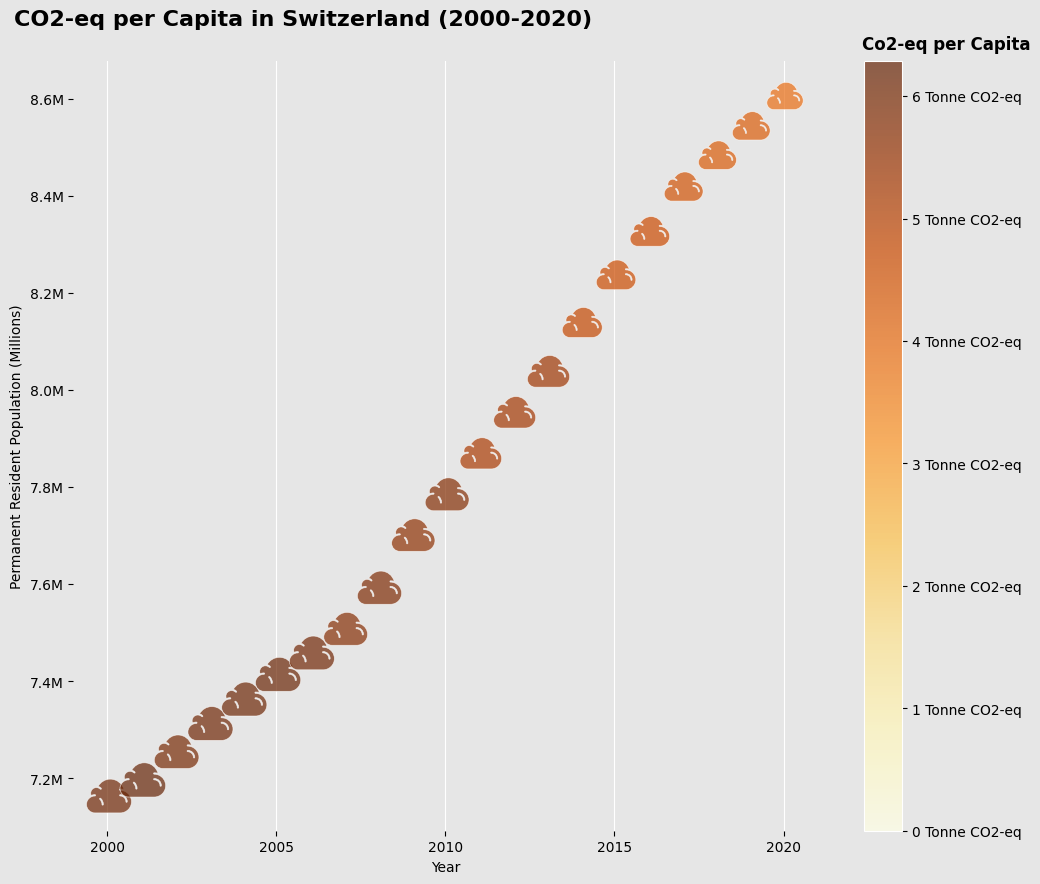

In [18]:
# Create a scatter plot
fig, ax = plt.subplots()
# Path to the SVG file for the cloud marker
cloud_path = r"./img/cloud.svg"
# Convert the SVG path to a marker
cloud_marker = svg_to_marker(cloud_path)
# Create a scatter plot with custom markers and colors
scatter = ax.scatter(
    df_b.index,  # x-values from the DataFrame
    df_b["Ständige Wohnbevölkerung"],  # y-values from the DataFrame
    c=df_b["CO2"],  # color based on CO2 values
    cmap=sns.color_palette("YlOrBr", as_cmap=True),  # colormap
    s=df_b["CO2"] * 200,  # marker size scaled by CO2 values
    alpha=0.7,  # transparency
    edgecolors="w",  # edge color
    linewidth=0.5,  # edge linewidth
    vmin=0,  # minimum value for color normalization
    marker=cloud_marker,
)  # custom cloud marker


# Set the title of the plot
ax.set_title(
    f"CO2-eq per Capita in Switzerland ({np.min(df_b.index)}-{np.max(df_b.index)})",
    x=-0.08,
    y=1.01,
)
# Set labels for the x and y axes
ax.set_xlabel("Year")
ax.set_ylabel("Permanent Resident Population (Millions)")
# Create and customize the colorbar
cbar = fig.colorbar(scatter, ticks=np.arange(0, 7, 1))
cbar.set_ticks(np.arange(0, 7, 1))
cbar.set_ticklabels([f"{i} Tonne CO2-eq" for i in range(7)])
# Set title for the colorbar
ax.text(
    1.06,
    1.01,
    f"Co2-eq per Capita",
    transform=ax.transAxes,
    va="bottom",
    fontsize=12,  # Adjust the font size as needed
    weight="bold",
)

# Adjust the appearance of the axes
nice_axes(ax)
# Set x-axis ticks
ax.set_xticks([x for x in range(2000, 2021, x_tick_steps)])
# Set y-axis tick labels to represent population in millions
y_tick_labels = [f"{y/1e6}M" for y in ax.get_yticks()]
ax.set_yticklabels(y_tick_labels)
# Display the plot
plt.show()

1. $CO_2$-eq = Sum of all gases; Non-CO2 emissions were converted according to their Global Warming Potential (GWP) (IPCC, Fourth Assessment Report).


To reduce greenhouse gas emissions, it is important to know which consumer group is responsible for these emissions. The lower graph shows how many tons of $CO_2$-eq each consumer group has emitted over the past 30 years.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

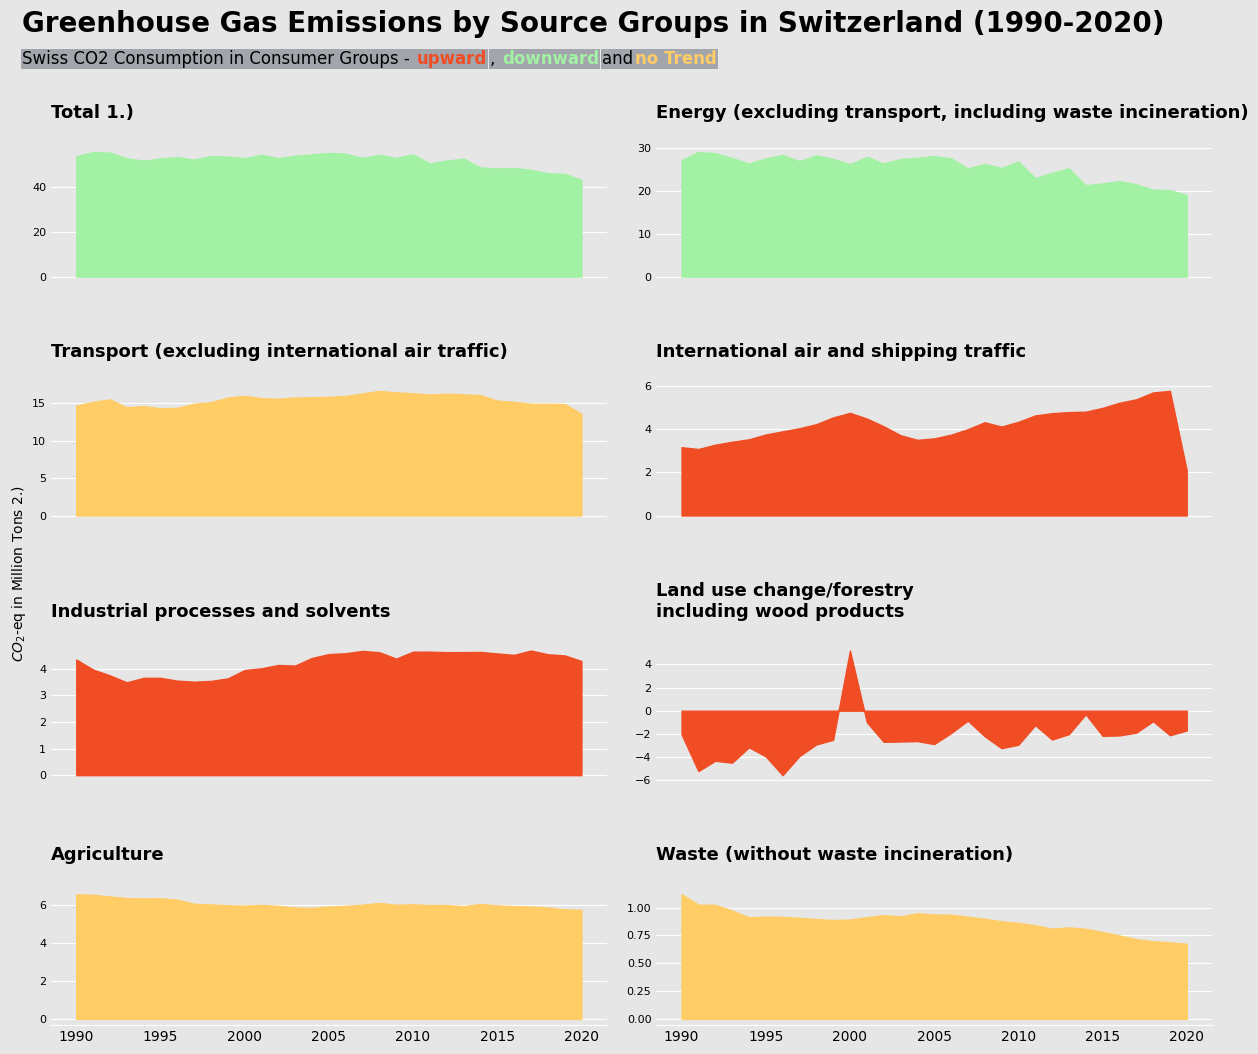

In [19]:
# Define color palette and text color
palette = {"Negative": "#A3F1A4", "Positive": "#F04D25", "None": "#ffcc66"}
text_col = "black"

# Title
title_text = f"Greenhouse Gas Emissions by Source Groups in Switzerland ({df_co2_con.index[0]}-{df_co2_con.index[-1]})"
titel_x_pos = 0
titel_y_pos = 1.05

# Subtitle
# Define formatted strings for up and down trends
up_list = ["upward", palette["Positive"], "bold"]
multi_and_list = [", ", text_col, "normal"]
and_list = ["and", text_col, "normal"]
down_list = ["downward", palette["Negative"], "bold"]
end_list = ["no Trend", palette["None"], "bold"]
subtitle_list = ["Swiss CO2 Consumption in Consumer Groups - ", text_col, "normal"]
subtitle = [subtitle_list, up_list, multi_and_list, down_list, and_list, end_list]

# Create subplots
fig, axes = plt.subplots(4, 2, constrained_layout=True)

# Loop through each subplot and plot data
for ax, typs in zip(axes.ravel(), df_co2_con.columns):
    subset = df_co2_con[typs]

    # Calculate trend and fill area between the data and trend
    trend = calculate_trend_decision(subset)
    ax.fill_between(df_co2_con.index, subset, color=palette[trend], alpha=1)

    ax.set_xticks([])
    ax.tick_params(labelsize=8, length=0)

    # Set subplot title
    ax.set_title(typs, fontdict={"family": "Arial", "size": 13, "weight": "bold"})

    # Style axes
    nice_axes(ax, "y")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

    # Style the x-axis for the last row of subplots
    if ax in axes[3]:
        ax.spines["bottom"].set_visible(True)
        ax.set_xticks([x for x in range(1990, 2021, x_tick_steps)])
        ax.set_xticklabels(
            [x for x in range(1990, 2021, x_tick_steps)],
            fontdict={
                "family": "Arial",
                "size": 10,
            },
        )

# Set title
fig.suptitle(title_text, x=titel_x_pos, y=titel_y_pos, ha="left", va="center")

# Adjust layout
fig.set_constrained_layout_pads(w_pad=0.1, h_pad=0.3)

multiple_colors_subtitel(fig, subtitle, subtitle_pos)

# Add ylabel for the entire figure (horizontally aligned to the left)
fig.text(
    -0.01,
    0.5,
    "$CO_2$-eq in Million Tons 2.)",
    horizontalalignment="left",
    verticalalignment="center",
    rotation="vertical",
)

# Display the plot
plt.show()

1.) Excluding international air travel and land-use change/forestry.

2.) $CO_2$-equivalents = Sum of all gases; Non-$CO_2$ emissions were converted according to their Global Warming Potential (GWP) (IPCC, Fourth Assessment Report).


Over three-quarters of the emitted greenhouse gases come from the Transport and Energy sectors. The Energy sector is the only sector showing a negative trend. The other sectors have remained steady or even slightly grown.

The consumer group Land-use change/Forestry, including wood products, is the only group reducing $CO_2$-equivalents. This is due to plants and photosynthesis. Photosynthesis converts carbon dioxide into oxygen. On December 26, 1999, the storm "Lothar" hit the Swiss Midlands with speeds of over 170 km/h, causing significant damage to the forests in Switzerland. As a result, extensive reforestation was carried out in 2000.

The impact of the COVID-19 pandemic is evident in the data for International Air and Sea Travel. In 2019, International Air and Sea Travel emitted around 5.76 tons of $CO_2$-equivalents, while in 2020, it emitted only around 2.1 tons of $CO_2$-equivalents. The pandemic led to a reduction of over 63% in $CO_2$-equivalents from International Air and Sea Travel in just one year.


In 2020, 44% of the emitted greenhouse gas emissions came from the Energy consumer group, which is over 19 tons of $CO_2$-equivalents.


# Long-Term Climate Strategy of Switzerland


- **Bern, August 28, 2019 - Switzerland, within the framework of the Paris Climate Agreement, has committed to halve its greenhouse gas emissions by 2030 compared to the 1990 level.**
- **From the year 2050, Switzerland aims to emit no net greenhouse gases.**

  - Signifies a balance between emission sources and sinks and includes all internationally regulated greenhouse gases (not just $CO_2$);
  - Encompasses all sectors of the greenhouse gas inventory (Energy, Industrial Processes and Product Use, Agriculture, Land Use, Land Use Change and Forestry (LULUCF), Waste, and Others);
  - Includes emissions within Swiss national borders (Territorial principle);
  - Additionally incorporates emissions attributable to Switzerland from international aviation and international shipping;
  - Does not specify domestic and foreign shares for emission reductions;
  - Marks an interim target, with further development beyond 2050 yet to be defined.
  - Road transport is expected to cause almost no greenhouse gas emissions in 2050, with few exceptions.

The goal of the Paris Climate Agreement is to limit global warming well below 2 degrees Celsius and, if possible, to 1.5 degrees Celsius. From a scientific perspective, achieving net-zero greenhouse gas emissions is crucial for meeting the goals of the Paris Climate Agreement.

If global warming continues, the costs in 2050 due to climate change could amount to 4% of annual GDP. In contrast, if the global goal of a maximum of 1.5 degrees Celsius were achieved, Switzerland would incur maximum costs of 1.5% of GDP in 2050. According to this estimate, it is in Switzerland's high interest to achieve the net-zero goal; the cost difference in 2050 would be roughly 2.5% of GDP. Approximately 20-30 billion Swiss francs can be very roughly estimated as 2.5% of annual GDP. With unchecked climate warming, costs grow exponentially.


### How Realistic is the Net-Zero Target?


The data shows there is still a long way to go to achieve the Net-Zero target in 2050. In 2020, Switzerland still emitted 43.4 million tons of $CO_2$-eq. The goal for Switzerland in 2030 is to emit only 26.98 million tons of $CO_2$-eq, meaning a reduction of 16.42 million tons of $CO_2$-eq needs to be achieved in 10 years, which is a reduction of 37.8%. To achieve the 2030 target, assuming a linear decrease in $CO_2$-eq emissions, Switzerland would need to save 1.64 million tons of $CO_2$-eq per year.

Since 1990, the trend of greenhouse gas emissions has been decreasing. However, if Switzerland continues to reduce greenhouse gas emissions at the same rate as it has since 1990, the Net-Zero target will clearly be missed. The Paris Agreement was ratified only in 2017. The linear regression since 2018 indicates the trend since 2018; if Switzerland continues to reduce greenhouse gas emissions at the same rate as it has since 2018, the Net-Zero target could be achieved by 2050.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

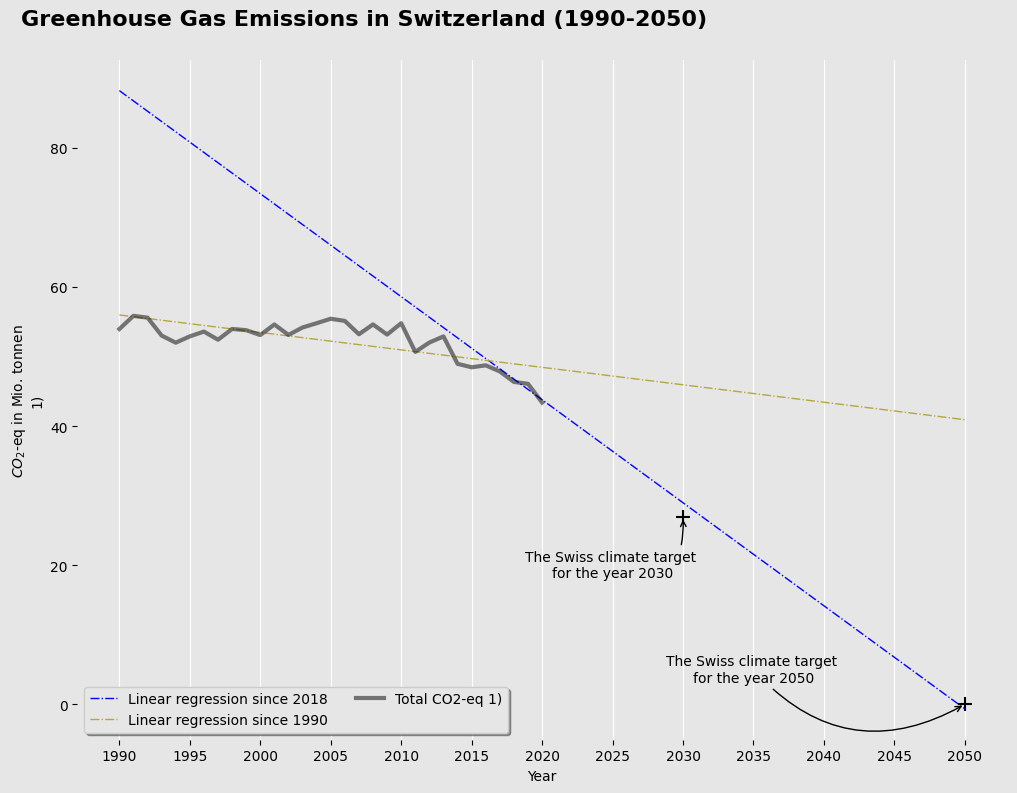

In [20]:
# Define the emission reduction goals for 2030 and 2050
goal_2030 = df_co2_con.loc[1990, "Total 1.)"] / 2
goal_2050 = 0

# Prepare data for linear regression
x_reg_2018 = np.array([2018, 2019, 2020]).reshape((-1, 1))
y_reg_2018 = df_co2_con.loc[[2018, 2019, 2020], "Total 1.)"].values

x_reg_1990 = np.array([x for x in range(1990, 2021)]).reshape((-1, 1))
y_reg_1990 = df_co2_con.loc[[x for x in range(1990, 2021)], "Total 1.)"].values

# Perform linear regression to get the slope and intercept
slope_2018, intercept_2018 = intercept_slope_reg(x_reg_2018, y_reg_2018)
slope_1990, intercept_1990 = intercept_slope_reg(x_reg_1990, y_reg_1990)

# Predict emissions over time using the regression parameters
X_predict = range(1990, 2051)
Y_predict_2018 = predict_over_time(X_predict, slope_2018, intercept_2018)
Y_predict_1990 = predict_over_time(X_predict, slope_1990, intercept_1990)

# Create a figure for the emission reduction goals
fig, ax_goal = plt.subplots()

ax_goal.set_title(
    f"Greenhouse Gas Emissions in Switzerland ({X_predict[0]}-{X_predict[-1]})",
    x=-0.06,
    y=1.01,
)
ax_goal.set_xlabel("Year")
ax_goal.set_ylabel("$CO_2$-eq in Mio. tonnen \n1)")

nice_axes(ax_goal)

# Plot the regression lines and historical emissions
ax_goal.plot(
    X_predict,
    Y_predict_2018,
    color=colmos_goal["progrnos_2018"][0],
    label=colmos_goal["progrnos_2018"][3],
    ls=colmos_goal["progrnos_2018"][1],
    lw=colmos_goal["progrnos_2018"][2],
)

ax_goal.plot(
    X_predict,
    Y_predict_1990,
    color=colmos_goal["progrnos_1990"][0],
    label=colmos_goal["progrnos_1990"][3],
    ls=colmos_goal["progrnos_1990"][1],
    lw=colmos_goal["progrnos_1990"][2],
)

ax_goal.plot(
    df_co2_con.index,
    df_co2_con["Total 1.)"],
    color=colmos_goal["Total_co2a_1"][0],
    label=colmos_goal["Total_co2a_1"][3],
    ls=colmos_goal["Total_co2a_1"][1],
    lw=colmos_goal["Total_co2a_1"][2],
    alpha=0.5,
)

# Plot the emission reduction goals as black markers
ax_goal.scatter(x=2030, y=goal_2030, color="black", marker="+", s=100)
ax_goal.scatter(x=2050, y=goal_2050, color="black", marker="+", s=100)

# Annotate the emission reduction goals with explanatory text
anno_goal_2030 = ax_goal.annotate(
    xy=(2030, goal_2030),
    text="The Swiss climate target \nfor the year 2030",
    xytext=(2025, 20),
    ha="center",
    va="center",
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.8"),
    zorder=99,
)

anno_goal_2050 = ax_goal.annotate(
    xy=(2050, goal_2050),
    text="The Swiss climate target \nfor the year 2050",
    xytext=(2035, 5),
    ha="center",
    va="center",
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.4"),
    zorder=99,
)

# Add legend and adjust the layout
legend = ax_goal.legend(
    loc="lower left", bbox_transform=fig.transFigure, fancybox=True, shadow=True, ncol=2
)
fig.subplots_adjust(bottom=0.2)

# Set custom x-axis ticks
ax_goal.set_xticks([x for x in range(1990, 2055, x_tick_steps)])

# Display the plot
plt.show()

1. $CO_2$-eq = Sum of all gases; Non-$CO_2$ emissions were converted according to their Global Warming Potential (GWP) (IPCC, Fourth Assessment Report).


The COVID-19 pandemic had a significant impact on the year 2020, leading to a reduction of 2.7 million tons of $CO_2$-eq compared to the previous year. The transportation sector saw the most significant reduction in greenhouse gas emissions, partly due to a considerable number of people working from home. The future trajectory of these numbers will depend on various factors, including the shift in energy consumption patterns.

The majority of greenhouse gas emissions result from the combustion of fossil fuels. The conflict in Ukraine has led to an increase in prices for fossil fuels, making alternative energies more attractive. For Switzerland, alternative energies are not only relevant from a financial perspective but also for ensuring the country's energy security.


# Energy Strategy 2050

On May 21, 2017, measures of the Energy Strategy 2050 were approved through a nationwide referendum in Switzerland. The law revision and regulation of the Energy Strategy 2050 came into effect on January 1, 2018. The Energy Act aims to reduce energy consumption, increase energy efficiency, and promote renewable energies. Additionally, the construction of new nuclear power plants is prohibited.

The Federal Office of Energy has set benchmarks for how much the energy consumption should be reduced.

**Average Energy Consumption per Person**

Reduction compared to the level in the year 2000

- 16% by the year 2020
- 43% by the year 2035

**Average Electricity Consumption per Person**

Reduction compared to the level in the year 2000

- 3% by the year 2020
- 13% by the year 2035

**Average Domestic Production of Renewable Energies excluding Hydropower**

- in the year 2020: 4,400 GWh
- in the year 2035: 11,400 GWh

**Hydropower**

- 37,400 GWh by the year 2035

In November 2020, the Energy Perspectives 2050+ report was published. This report analyzes various scenarios for achieving Net-Zero emissions, assuming the energy security of Switzerland is ensured. The graph below plots the ZERO Basic scenario against the Business as Usual (BAU) scenario to assess compliance with the regulations of the Energy Strategy 2050.

The ZERO Basic scenario assumes a foreseeable trend in technological development in the future. It anticipates early improvements in energy efficiency and significant electrification. Remaining greenhouse gas emissions are compensated for by sinks or negative emission technologies, either domestically or internationally.

The BAU scenario reflects the instruments of current energy and climate policies, market conditions, and other framework conditions in the electricity market (as of January 1, 2019). The expansion of renewable energies, hydropower plants, and other power plant capacities in the electricity sector also considers existing conditions.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

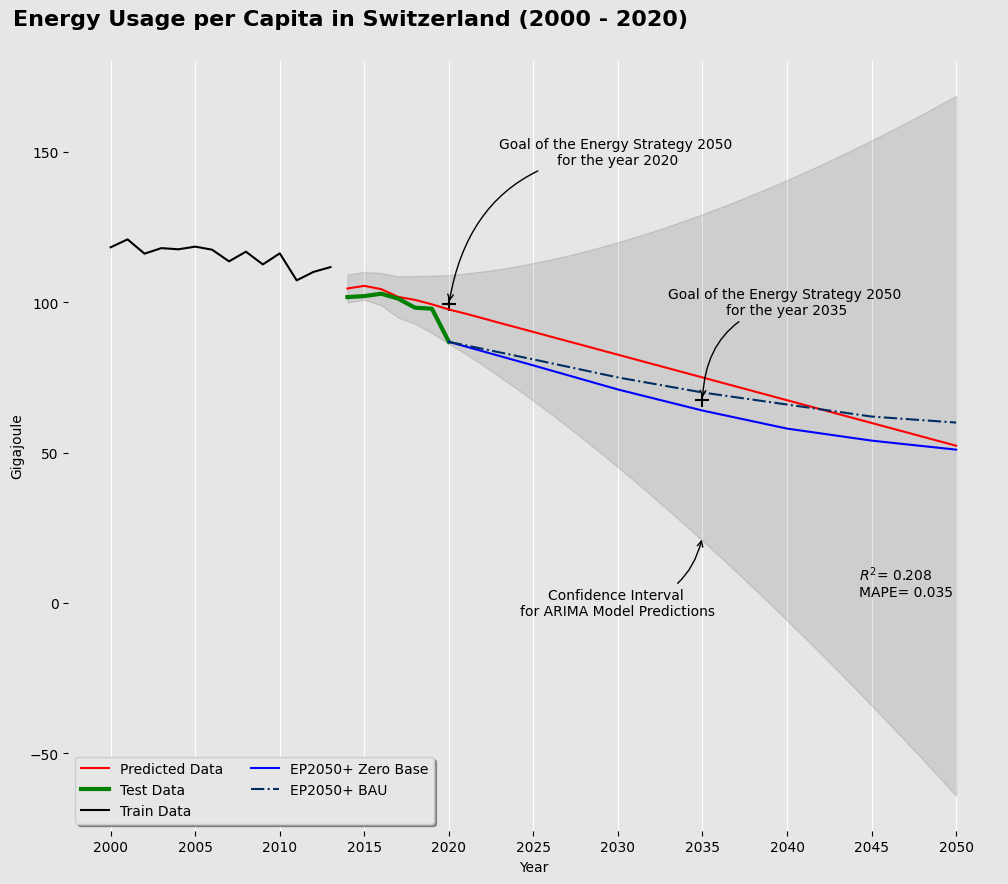

In [21]:
warnings.filterwarnings("ignore", category=UserWarning)
# Calculate the net energy consumption by summing across columns


df_enver["Netto"] = df_enver.sum(axis=1)


# Concatenate the two DataFrames and sort the index


df = pd.concat([df_b, df_enver], axis=1, join="outer")


df = df.sort_index().drop_duplicates().dropna(axis=0)


# Calculate total therajoul and gigajoules per person


df["Total Therajoul"] = df["Netto"] * 1000


df["Gigajoule pro Person"] = (
    df["Total Therajoul"] / df["Ständige Wohnbevölkerung"] * 1000
)  # Umrechnen in GJ



# Set goals for the energy strategy in 2050 for the years 2020 and 2035



df["Ziel der Energiestrategie 2050 für das Jahr 2020"] = (
    df.loc[2000]["Gigajoule pro Person"] * 0.84
)
df["Ziel der Energiestrategie 2050 für das Jahr 2035"] = (
    df.loc[2000]["Gigajoule pro Person"] * 0.57
)



# Define energy consumption goals for specific years



ep_zBas_enver = {2025: 79, 2030: 71, 2035: 64, 2040: 58, 2045: 54, 2050: 51}


ep_wwb_enver = {2025: 81, 2030: 75, 2035: 70, 2040: 66, 2045: 62, 2050: 60}



# Assign the energy consumption for the year 2020 to the defined goals



ep_zBas_enver[2020] = df.loc[2020]["Gigajoule pro Person"]



ep_wwb_enver[2020] = df.loc[2020]["Gigajoule pro Person"]



# Assign the energy consumption for the year 2020 to the defined goals



ep_zBas_enver = {k: v for k, v in sorted(ep_zBas_enver.items())}


ep_wwb_enver = {k: v for k, v in sorted(ep_wwb_enver.items())}



# Generate a list of years from 2000 to 2050



x_gole = [x for x in range(2000, 2051)]



# Define the target column for ARIMA forecasting


target_column = "Gigajoule pro Person"



# Create an ARIMA time series forecast object



arima_forecast = ARIMATimeSeriesForecast(df, target_column)



# Fit the ARIMA model with a specified order and forecast the next 30 steps


arima_forecast.fit(order=(2, 2, 2), forecast_steps=30)


prediction = arima_forecast.predict()



# Evaluate the ARIMA model and obtain R^2 and MAPE values


r2, mape = arima_forecast.evaluate()



# Set labels and title for the plot


y_label = "Gigajoule"


x_label = "Year"



titel = "Energy Usage per Capita in Switzerland"



# Create a plot with ARIMA results


fig, ax = arima_forecast.plot_results(titel, x_label, y_label)



# Scatter plot points for energy strategy goals in 2020 and 2035


ax.scatter(
    x=2020,
    y=df["Ziel der Energiestrategie 2050 für das Jahr 2020"].unique(),
    color="black",
    marker="+",
    s=100,
)



anno_goal_2030 = ax.annotate(
    xy=(2020, df["Ziel der Energiestrategie 2050 für das Jahr 2020"].unique()),
    text="Goal of the Energy Strategy 2050 \nfor the year 2020",
    xytext=(2030, 150),
    ha="center",
    va="center",  # move the center of the annotation to the point
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.4"),
    zorder=99,
)



ax.scatter(
    x=2035,
    y=df["Ziel der Energiestrategie 2050 für das Jahr 2035"].unique(),
    color="black",
    marker="+",
    s=100,
)



anno_goal_2030 = ax.annotate(
    xy=(2035, df["Ziel der Energiestrategie 2050 für das Jahr 2035"].unique()),
    text="Goal of the Energy Strategy 2050 \nfor the year 2035",
    xytext=(2040, 100),
    ha="center",
    va="center",  # move the center of the annotation to the point
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.4"),
    zorder=99,
)



# Annotation for the confidence interval of ARIMA model predictions


confidence_interval = ax.annotate(
    xy=(2035, 22),
    text="Confidence Interval \nfor ARIMA Model Predictions",
    xytext=(2030, 0),
    ha="center",
    va="center",  # move the center of the annotation to the point
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.4"),
    zorder=99,
)



# Plot lines for energy consumption goals



ax.plot(
    ep_zBas_enver.keys(),
    ep_zBas_enver.values(),
    color="Blue",
    label="EP2050+ Zero Base",
)



ax.plot(
    ep_wwb_enver.keys(),
    ep_wwb_enver.values(),
    color="#002e63",
    label="EP2050+ BAU",
    ls="-.",
)



# Display legend, adjust axes, and show the plot



ax.legend(
    loc="lower left", bbox_transform=fig.transFigure, fancybox=True, shadow=True, ncol=2
)



nice_axes(ax)



ax.set_xticks(range(2000, 2051, x_tick_steps))


plt.show()

The trend for per capita energy consumption in Switzerland is decreasing. The goal of the Energy Strategy 2050 was achieved for the year 2020. The target for 2020 was a 16% reduction in per capita energy consumption compared to the year 2000, which corresponds to a savings of 18.92 GJ per person.

The BAU scenario would narrowly miss the target of the Energy Strategy 2050 for the year 2035. The goals of the Energy Strategy 2050 are only guidelines and are not legally binding. However, the ZERO Basic scenario would achieve the 2035 target if everything goes according to plan.


## Electricity Trends


As electricity serves as a primary substitute for fossil fuels, it is interesting to examine the per capita electricity consumption figures in Switzerland. Until 2006, electricity consumption in Switzerland was still on the rise. In recent years, there has been a declining trend, mainly because many electrical appliances are becoming more efficient. The goal of the Energy Strategy 2050 for the year 2020 was clearly achieved. The target for 2020, a 3% reduction compared to 2000, was actually reached in 2014. When the Energy Strategy 2050 came into effect in 2018, each person in Switzerland could have consumed an additional 0.28 kWh, and the goal would still have been met.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

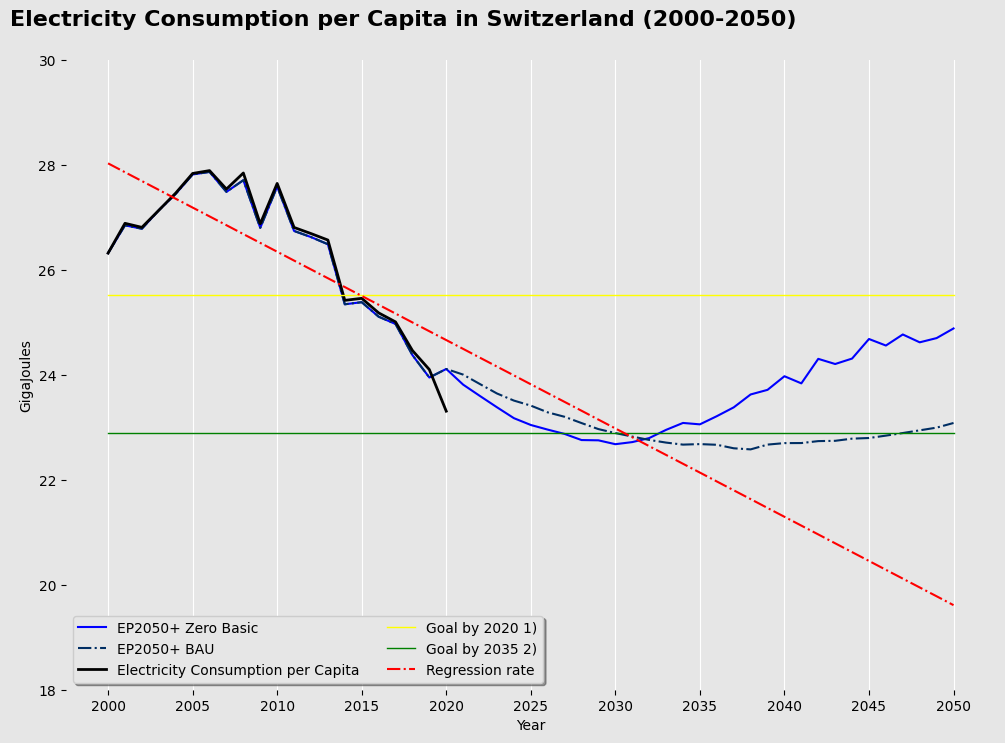

In [22]:
# Extracting relevant data
energy_consumption = df_enver["Elektrizität"]
energy_consumption = energy_consumption[-21:]
population = df["Ständige Wohnbevölkerung"]

# Electricity consumption in GigaJoules per person
electricity_per_capita = energy_consumption / population * 1_000_000
x = electricity_per_capita.index

# Energy Program Goals
ep_zero_basis = {
    2000: 56.3,
    2019: 61.5,
    2025: 62.5,
    2030: 64.1,
    2035: 67.4,
    2040: 71.5,
    2045: 74.6,
    2050: 76,
}
ep_wwb = {
    2000: 56.3,
    2019: 61.5,
    2025: 63.5,
    2030: 64.7,
    2035: 66.3,
    2040: 67.7,
    2045: 68.9,
    2050: 70.5,
}

# Projected Population
projected_population = [
    7_164_444,
    8_544_527,
    8_625_513,
    9_180_500,
    9_817_000,
    9_963_668,
    10_110_334,
    10_257_000,
]

# Conversion of TWh to GJ per person


def convert_TWh_to_GJ_per_person(dictionary, population):
    z = 0
    for year in dictionary:
        dictionary[year] = dictionary[year] * 3_600_000 / population[z]
        z += 1
    return dictionary


ep_zero_basis = convert_TWh_to_GJ_per_person(ep_zero_basis, projected_population)
ep_wwb = convert_TWh_to_GJ_per_person(ep_wwb, projected_population)

# Plotting parameters
color_electricity = "Black"
label_electricity = "Electricity Consumption per Capita"
line_style = "-"
line_width = 2

y = [
    [
        electricity_per_capita.values,
        color_electricity,
        label_electricity,
        line_style,
        line_width,
    ]
]

title = f'Electricity Consumption per Capita in Switzerland ({np.min(df_EP2050_Electricity["Jahr"])}-{np.max(df_EP2050_Electricity["Jahr"])})'
xlabel = "Year"
ylabel = "GigaJoules"

line_style_goal = "-"
line_width_goal = 1

# Program goals
goal_1_electricity = y[0][0][0] * 0.97
label_goal_1 = "Goal by 2020 1)"
color_goal_1 = "yellow"

goal_2_electricity = y[0][0][0] * 0.87
label_goal_2 = "Goal by 2035 2)"
color_goal_2 = "green"

goals = [
    [goal_1_electricity, color_goal_1, label_goal_1, line_style_goal, line_width_goal],
    [goal_2_electricity, color_goal_2, label_goal_2, line_style_goal, line_width_goal],
]
goal_range = (2000, 2051)

y_min = 18
y_max = 30
subplots_adjust = 0.25

# Plotting the results
fig, ax_electricity_prog = plt.subplots()

ax_electricity_prog.plot(
    df_EP2050_Electricity["Jahr"],
    df_EP2050_Electricity["Landesverbrauch  ZERO Basis Pro Person"] / 1.072071032878835,
    color="Blue",
    label="EP2050+ Zero Basic",
    ls="-",
)
ax_electricity_prog.plot(
    df_EP2050_Electricity["Jahr"],
    df_EP2050_Electricity["Landesverbrauch WWB Pro Person"] / 1.072071032878835,
    color="#002e63",
    label="EP2050+ BAU",
    ls="-.",
)

ax_electricity_prog = check_goals(
    ax_electricity_prog,
    x,
    y,
    title,
    xlabel,
    ylabel,
    goals,
    goal_range,
    y_min,
    y_max,
    subplots_adjust,
    x_tick_steps,
)

plt.show()

From the year 2030, an increase in electricity consumption is anticipated, mainly due to the efforts in Switzerland to reduce fuel consumption through electromobility. Another factor contributing to the rise in electricity consumption is the transition from conventional oil and gas heating to heat pumps. The ZERO Basic scenario indicates a significantly higher electricity consumption compared to the BAU scenario. The additional required electricity is intended to be generated through renewable energy sources.


### Electricity Generation (GWh) in Switzerland


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

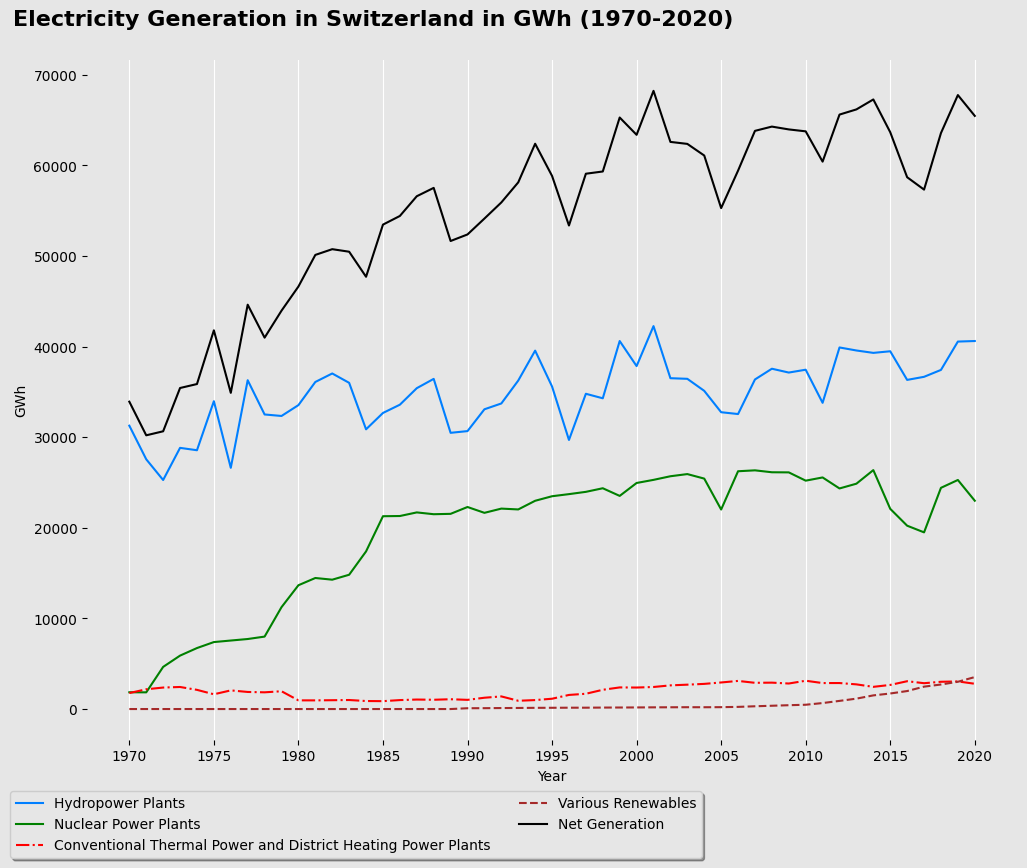

In [23]:
# Extracting data for plotting
x = df_el.index
labels_name = [
    "Hydropower Plants",
    "Nuclear Power Plants",
    "Conventional Thermal Power and District Heating Power Plants",
    "Various Renewables",
    "Net Generation",
]
labels_df_name = [
    "Wasserkraftwerke ",
    "Kernkraftwerke",
    "Konventionell thermische Kraft- und Fernheizkraftwerke",
    "Diverse Erneuerbare 1)",
    "Nettoerzeugung ",
]

colors_el = ["#007fff", "#008000", "Red", "#a52a2a", "#000000"]
line_styles_el = ["-", "-", "-.", "--", "-"]

values = df_el.iloc[-1] - df_el.iloc[0]
plot_items = zip(labels_df_name, labels_name, colors_el, line_styles_el)
# Creating the plot
fig, ax_el = plt.subplots()

for label_df, label_name, color, line_style in plot_items:
    ax_el.plot(x, df_el[label_df], label=label_name, color=color, ls=line_style)


# Adding legend
legend = ax_el.legend(
    loc="lower left",
    bbox_transform=fig.transFigure,
    fancybox=True,
    shadow=True,
    ncol=2,
    bbox_to_anchor=(0.055, 0.075),
)
plt.subplots_adjust(bottom=0.2)

# Adjusting axes and labels
nice_axes(ax_el)
ax_el.set_title(
    f"Electricity Generation in Switzerland in GWh ({np.min(df_el.index)}-{np.max(df_el.index)})",
    x=-0.08,
    y=1.01,
)
ax_el.set_xlabel("Year")
ax_el.set_ylabel("GWh")

# Setting custom x-axis ticks
plt.xticks([x for x in range(1970, 2025, x_tick_steps)])
plt.show()

Since 1970, electricity production in Switzerland has been growing. The majority of the electricity in Switzerland is generated through hydropower, followed by nuclear power. 91% of the generated electricity comes from hydropower and nuclear power plants. Operating both types of power plants appears to have the advantage of not causing direct CO2 emissions. However, this advantage is deceptive because greenhouse gas emissions are largely associated with the upstream and downstream processes of electricity production. The uranium for nuclear power plants must be mined, enriched, and stored for a very long time, and these processes produce greenhouse gases.

In Switzerland, only about 4% of the generated electricity comes from conventional thermal power and district heating power plants. Conventional thermal power and district heating power plants include fossil fuel power plants such as coal, oil, and gas power plants.


### Electricity Import and Export in Switzerland


Analyzing the import and export behavior of electricity in Switzerland provides insight into whether Switzerland produces enough or not enough electricity for its own needs. Since Switzerland relies on electricity as an energy source to reduce CO2 equivalents, it is crucial to ensure that Switzerland generates enough electricity. This ensures that the generated electricity is climate-neutral and does not come from German or Italian gas or coal power plants.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

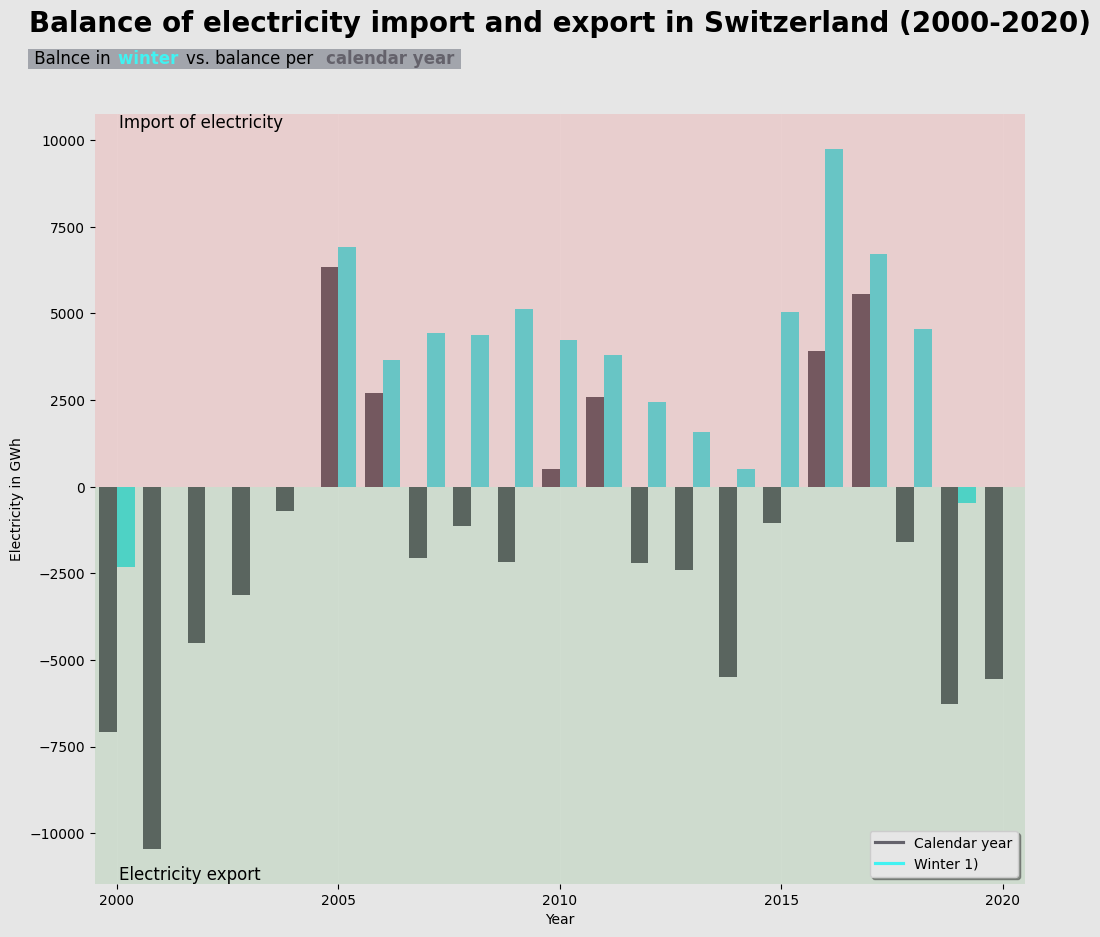

In [24]:
# Dictionary with column names, labels, and colors for electricity import and export balance
columns_Energieeinfuhr_und_ausfuhr = {
    "Elektrizität_GWh.Sal": ["Calendar year", "#64626b"],
    "Elektrizität_GWh.Winter": ["Winter 1)", "#41f2f2"],
}

# Select columns and filter rows based on the index
df_Energieeinfuhr_und_ausfuhr = df_Energieeinfuhr_und_ausfuhr[
    df_Energieeinfuhr_und_ausfuhr.index >= 2000
]
df_Energieeinfuhr_und_ausfuhr = df_Energieeinfuhr_und_ausfuhr[
    list(columns_Energieeinfuhr_und_ausfuhr.keys())
]

# Extract column names and colors from the dictionary
column_names = list(columns_Energieeinfuhr_und_ausfuhr.keys())
column_labels = [value[0] for value in columns_Energieeinfuhr_und_ausfuhr.values()]
column_colors = [value[1] for value in columns_Energieeinfuhr_und_ausfuhr.values()]

# Reset the index for melting the DataFrame
df_melted = df_Energieeinfuhr_und_ausfuhr.reset_index()

# Set title and subtitle for the plot
title = "Balance of electricity import and export in Switzerland (2000-2020)"
subtitle = [
    [" Balnce in ", "black", "normal"],
    [
        "winter ",
        columns_Energieeinfuhr_und_ausfuhr["Elektrizität_GWh.Winter"][1],
        "bold",
    ],
    ["vs. balance per  ", "black", "normal"],
    [
        "calendar year ",
        columns_Energieeinfuhr_und_ausfuhr["Elektrizität_GWh.Sal"][1],
        "bold",
    ],
]

# Use the melt function to reshape the DataFrame
df_melted = df_melted.melt(
    id_vars="Jahr",
    var_name="Saldo Elektrizitäteinfuhr und - ausfuhr",
    value_name="Elektrizität in GWh",
)

# Create a bar plot
fig, ax = plt.subplots()
sns.barplot(
    data=df_melted,
    x="Jahr",
    y="Elektrizität in GWh",
    hue="Saldo Elektrizitäteinfuhr und - ausfuhr",
    palette=column_colors,
    ax=ax,
)

# Adjust legend labels and colors
legend = ax.legend(
    labels=column_labels,
    loc="lower right",
    fancybox=True,
    shadow=True,
    handlelength=2.0,
)

for i, handle in enumerate(legend.legendHandles):
    handle.set_color(column_colors[i])

# Set x-axis tick labels in 5-step intervals
x_labels = df_melted["Jahr"].unique().tolist()
step = x_tick_steps
x_ticks = list(range(0, len(x_labels), step))
x_tick_labels = [x_labels[i] for i in x_ticks]

ax.set_xticks(ticks=x_ticks, labels=x_tick_labels)
ax.grid(True, axis="x", color="gray", alpha=0.1)
[spine.set_visible(False) for spine in ax.spines.values()]

# Highlight regions with red and green shading
ylim_min, ylim_max = ax.get_ylim()
ax.axhspan(0, ylim_max, facecolor="red", alpha=0.1)
ax.axhspan(0, ylim_min, facecolor="green", alpha=0.1)

ax.set_ylim(ylim_min, ylim_max)

# Adjust layout
nice_axes(ax)
fig.set_constrained_layout_pads(w_pad=0.1, h_pad=0.3)

# Set title and subtitle
fig.suptitle(title, x=titel_x_pos + 0.07, y=titel_y_pos - 0.08, ha="left", va="center")

# Position the subtitle
multiple_colors_subtitel(
    fig=fig,
    subtitle=subtitle,
    subtitle_pos=[subtitle_pos[0] + 0.07, subtitle_pos[1] - 0.08],
)

# Set axis labels
ax.set_xlabel("Year")
ax.set_ylabel("Electricity in GWh")

# Add text annotations for electricity export and import
ax.text(0.05, ylim_min, "Electricity export", fontsize=12, va="bottom", ha="left")
ax.text(0.05, ylim_max, "Import of electricity", fontsize=12, va="top", ha="left")

# Show the plot
plt.show()

1. Winter According to the Hydrological Year


It is evident that Switzerland regularly relies on importing electricity to meet its demand during the winter months. The transition from conventional oil and gas heating to heat pumps has contributed to an increase in winter electricity consumption. Therefore, it is crucial to handle electricity efficiently during the winter months. However, this challenge cannot be addressed solely by saving electricity; it requires climate-neutral solutions for electricity generation and storage during the winter.

Switzerland faces the challenge of meeting the rising demand for winter electricity through sustainable and environmentally friendly energy sources. This may involve expanding renewable energy, developing storage technologies, and strengthening cross-border energy cooperation with neighboring countries.


# Steps for Active Change


Even though climate change is a global issue, each of us in Switzerland can make a significant contribution to combating it. Here are some specific actions that each of us can take:

1. **Increase Energy Efficiency:** Reduce your home energy consumption by using energy-efficient appliances and insulation.

2. **Use Public Transportation:** Utilize public transportation or carpool to reduce your individual carbon footprint.

3. **Support Renewable Energy:** Consider investing in renewable energy such as solar or wind power to contribute to reducing greenhouse gas emissions.

4. **Practice Sustainable Eating:** Prefer local, seasonal foods and reduce meat consumption to minimize the environmental impact of food production.

5. **Get Politically Involved:** Engage in politics, support environmentally friendly policies, and contribute to bringing about changes at the political level.


# Conclusion


In conclusion, it is emphasized that climate change is one of the most pressing challenges of our time. The facts and data in this post indicate that we need drastic changes in our behavior and policies to address these global threats.

Switzerland has already taken steps to reduce its CO2 emissions, but more needs to be done. Everyone can contribute, whether through energy conservation, sustainable eating, or political participation.

It is up to us to shape the future of our planet and ensure that future generations inherit a livable world. The costs of inaction are enormous, but the opportunities to effect positive change are also significant.

Let's act together to curb climate change and secure a sustainable, thriving future. Every step we take counts. Let's be the change we want to see in the world.
